In [1]:
using Catalyst: spatial_convert_err
include("../src/DiscreteStochasticSimulation.jl")
using .DiscreteStochasticSimulation
using Catalyst
using ProgressMeter
using Plots
using Expokit
using DifferentialEquations
using OrdinaryDiffEq

## Lotka Volterra Chemical Reaction Network Definition using Catalyst.jl DSL

In [2]:
 local k₁, k₂, k₃, X, Y
  rn = @reaction_network begin
    k₁, X --> 2X
    k₂, X + Y --> 2Y
    k₃, Y --> 0
  end

Model ##ReactionSystem#231
Unknowns (2):
  X(t)
  Y(t)
Parameters (3):
  k₁
  k₂
  k₃

## Plug in the reaction network structure into the discrete system wrapper

In [3]:
model = DiscreteStochasticSystem(rn);

## Define boundary condition function

Rectangular lattice simply means the solver won't consider states beyond the limits

In [4]:
 # define boundaries (rectangular lattice in this case)
bounds = (0, 500) #(lower limit, upper limit)
boundary_condition(x) = RectLatticeBoundaryCondition(x, bounds);

## Define initial state and place it in a set, then expand the space 

In [5]:
# define initial value and expand the space a bit 
U₀ = CartesianIndex(50, 100)
X = Set([U₀])
X = Expand!(X, model, boundary_condition, 2);

## Define a probability density vector over the initial state space and set the probability of initial value to 1 (rest to zero)

In [6]:
 # initial probability vector (only for active states)
p₀ = zeros(X |> length)
p₀[DiscreteStochasticSimulation.FindElement(U₀, X)] = 1

# probability values for the entire state space (visalization only)
P = zeros(bounds[2], bounds[2]);
P1 = zeros(bounds[2], bounds[2]); # this will hold active states

## Run the simulation (sliding windows algorithm for fiite state projection)

In [7]:
δt = 0.01
global iter = 1
global pₜ = p₀

# time intrerval 
T = 0:δt:20

sol = zeros(length(T), size(P)...)
sizes = zeros(length(T), size(P)...)

@showprogress for t ∈ T
    
  #expand space and assemble matrix
  global X, pₜ = Expand!(X, pₜ, model, boundary_condition, 7)
  A = MasterEquation(X, model, [1.0, 0.005, 0.6], boundary_condition, t)
    
  # solve system and normalize (using expokit (can also use numerical time steppers such as Runge-Kutta))
  global pₜ = expmv(δt, A, pₜ)
  pₜ /= sum(pₜ)
    
  # purge lowest 80% probability states (most will be zero; this is arbitrary as of now)
  X, pₜ = Purge!(X, pₜ, 60)
    
  # set probability values to full space for visualization using heatmap
  P .= 0 
  P1 .= 0
  P[X|>collect] = pₜ
  P1[X|>collect] .= 1

  sol[iter, :, :] .= P 
  sizes[iter, :, :] .= P1
  iter+=1
     
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:11


# Calculate FSP mean trajectory

In [8]:
cart2vec(x) = [Tuple(x)...]
points = cart2vec.(CartesianIndices(sol[1, :, :]))
sol_mean = @showprogress map(1:length(T)) do i
    local vals =  points .* sol[i, :, :] 
    sum([vals...])
end

x = [sol_mean[i][1] for i ∈ 1:length(sol_mean)]
y = [sol_mean[i][2] for i ∈ 1:length(sol_mean)]
fsp_mean_sol = hcat(x, y) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


2001×2 Matrix{Float64}:
  50.2406  99.6311
  50.4999  99.2973
  50.7549  98.9534
  51.0104  98.609
  51.2655  98.2627
  51.5154  97.9058
  51.7668  97.5511
  52.0084  97.178
  52.2424  96.7902
  52.4805  96.4148
  52.709   96.023
  52.9343  95.6263
  53.1632  95.2361
   ⋮       
 130.357   58.9439
 131.269   58.9702
 132.242   59.0147
 133.169   59.0457
 133.869   58.9832
 134.855   59.0336
 135.781   59.0547
 136.775   59.1122
 137.747   59.1507
 138.701   59.1829
 139.669   59.2248
 140.628   59.2555

In [9]:
# Create an ODE that can be simulated.
u0 = [:X=>50, :Y=>100]
tspan = (0., 20.)
ps = [:k₁=>1.0, :k₂=>0.005, :k₃=>0.6]
ode = ODEProblem(rn, u0, tspan, ps)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 20.0)
u0: 2-element Vector{Float64}:
  50.0
 100.0

# True ODE solution

In [10]:
ode = ODEProblem(rn, u0, tspan, ps)
rsol = solve(ode, saveat=0.01);

# SSA solution

In [11]:
using JumpProcesses

jinput = JumpInputs(rn, u0, tspan, ps)
jprob = JumpProblem(jinput)

n_trajs = 1000
ssa_trajs = map(1:n_trajs) do _
    solve(jprob,  SSAStepper(); saveat=0.1)
end;

## Mean SSA Trajectory 

In [12]:
ssa_mean = zeros(length(T), length(ssa_trajs[1].u[1]))
for i in 1:length(T)-1
    for (j, traj) in enumerate(ssa_trajs)
        idxs = findall( (traj.t .> T[i]) .& (traj.t .< T[i+1])) 
        if length(idxs) > 0
            ssa_mean[i, :] .+= sum(traj.u[idxs]) / length(idxs)
        end
    end
    ssa_mean[i, :] ./= length(ssa_trajs)
end

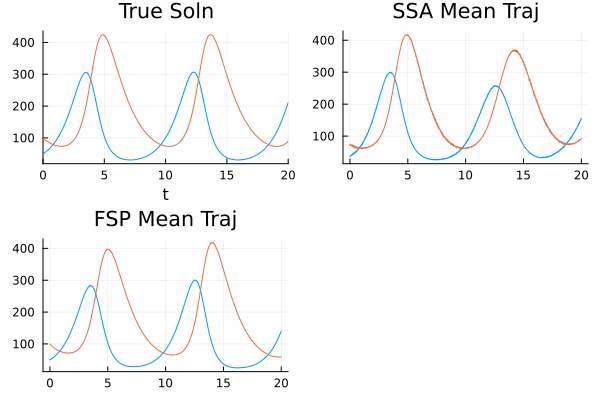

In [13]:
p1=plot(rsol, title="True Soln", legend=false)
p2=plot(collect(T[1:end-1]), ssa_mean[1:end-1, :], title="SSA Mean Traj", legend=false)
p3=plot(collect(T[1:end]), fsp_mean_sol[1:end, :], title="FSP Mean Traj", legend=false)
plot(p1, p2, p3)

[ Info: Saved animation to /home/adiden/DiscreteStochasticSimulation/examples/anim_fps15.gif


Plots.AnimatedGif("/home/adiden/DiscreteStochasticSimulation/examples/anim_fps15.gif")
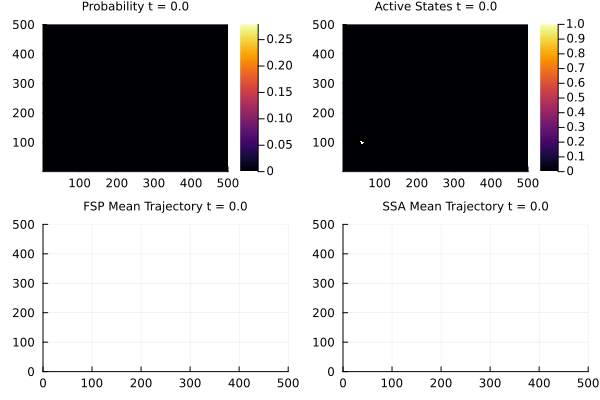

In [15]:
a = @animate for i ∈ 1:length(T)

    # two heatmaps first col 
    h = heatmap(sol[i, :, :]')
    s = heatmap(sizes[i, :, :]')

    # bottom left plot
    p1 = plot(fsp_mean_sol[1:i, 1], fsp_mean_sol[1:i, 2];legend=false)
    xlims!(p1, (0, 500))
    ylims!(p1, (0, 500))

    # bottom left plot
    p2 = plot(ssa_mean[1:i, 1], ssa_mean[1:i, 2];legend=false)
    xlims!(p2, (0, 500))
    ylims!(p2, (0, 500))

    # title for each polot
    title!(h, "Probability t = $(T[i])", titlefontsize=8)
    title!(s, "Active States t = $(T[i])", titlefontsize=8)
    title!(p1, "FSP Mean Trajectory t = $(T[i])", titlefontsize=8)
    title!(p2, "SSA Mean Trajectory t = $(T[i])",titlefontsize=8)


    plot(h, s, p1, p2, layout=grid(2, 2,  size=(700, 700)))
end every 10
gif(a, "anim_fps15.gif")